In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/CS_project/Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random
#using ControlSystems

### 2D Point Mass Continous dynamics

In [3]:
c = 0.1
m = 1.0
function point_mass(x, u)
   # x = state[1]                #x_1 = ẋ
    ẋ = x[3]
    ẍ = -(c/m)*ẋ + u[1]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    #y = state[3]
    ẏ = x[4]
    ÿ = -(c/m)*ẏ + u[2]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    return [ẋ; ẏ; ẍ; ÿ]
end

point_mass (generic function with 1 method)

### Linearizing and discretizing the dynamics

In [4]:
function lin_dyn_discrete(dynamics, x, u, dt)
    A = ForwardDiff.jacobian(dx -> dynamics(dx, u), x)
    B = ForwardDiff.jacobian(du -> dynamics(x, du), u)
    A = dt .* A + I
    B = dt .* B
    return A, B
end

lin_dyn_discrete (generic function with 1 method)

In [5]:
# Constraint 
obstacle = [10.0, 10.0, 0.0, 0.0]
dmax = 3.0

outside_weight = 1000.0

1000.0

### Cost Function (add distance constrain to arbitary static object)

In [6]:
Q = 100.0*I(4) #state cost for point mass 1
R = 0.1*I(2)
Qn = 100.0*I(4)

# function cost(x, u)
#     c = 0.5*x'*Q*x + 0.5*u'*R*u + rho*min(sqrt((x[1:2] - obstacle[1:2])'*(x[1:2] - obstacle[1:2])), 0)
#     return c
# end

function cost(x, x̂, u, û, xgoal, B)

    goal = xgoal - x̂ # check x or x̂

    if B 
        return 0.5*goal'*Qn*goal
    else            
        dx = x - x̂
        du = u - û
        return 0.5*dx'*Q*dx + 0.5*du'*R*du
    end
end

# rel_dist = (x[1:2] - obstacle[1:2])'*(x[1:2] - obstacle[1:2])
# if rel_dist < dmax 
#     c = 0.5*x'*Q*x + 0.5*u'*R*u - rel_dist
# else
#     outside_penalty = outside_weight*(rel_dist + dmax - 2*sqrt(rel_dist*dmax))
#     c = 0.5*x'*Q*x + 0.5*u'*R*u - outside_penalty - dmax
# end

cost (generic function with 1 method)

### Quadritizing cost function

In [84]:
function quadratic_cost(cost_fun, x, x̂, u, û, xgoal, B)
    """
    2nd order Taylor expansion of cost at t
    I neglected the mixed paritals in the hessian
    """
    Q = ForwardDiff.hessian(dx -> cost_fun(x, dx, u, û, xgoal, B), x̂)
    l = ForwardDiff.gradient(dx -> cost_fun(x, dx, u, û, xgoal, B), x̂)
    R = ForwardDiff.hessian(du -> cost_fun(x, x̂, u, du, xgoal, B), û)
    r = ForwardDiff.gradient(du -> cost_fun(x, x̂, u, du, xgoal, B), û)

    dx = x - x̂
    du = u - û

    cost = 0.5 * dx' * (Q*dx + 2*l) + 0.5 * du' * (R*du + 2*r)
    return cost, Q, l, R, r
end

quadratic_cost (generic function with 1 method)

In [85]:
xₜ = [1.0; 1.0; 0.0; 0.0]
x̂ = [2.0; 2.0; 0.0; 0.0]
xgoal = [3.0; 3.0; 0.0; 0.0]

uₜ = [2.0; 2.0]
û = [0.0; 0.0]

costs, Qₜ, lₜ, Rₜ, rₜ = quadratic_cost(cost, xₜ, x̂, uₜ, û, xgoal, true)

@show costs
@show Qₜ
@show lₜ
@show Rₜ
@show rₜ

costs = 900.0
Qₜ = [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 100.0 0.0; 0.0 0.0 0.0 100.0]
lₜ = [-400.0, -400.0, 0.0, 0.0]
Rₜ = [0.0 0.0; 0.0 0.0]
rₜ = [0.0, 0.0]


2-element Vector{Float64}:
 0.0
 0.0

#### Point Mass Discrete

$$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$


### Single Iteration of Affine QR

In [86]:
n = 4 #8 states
m = 2 #2 controls
function affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ)

    V = copy(Qₜ[:,:,end]) #at last time step
    ζ = copy(lₜ[:,end]) #at last time step
    #P = zeros(k_steps, n*m)
    P = zeros(Float32, (m, n, k_steps))
    #α = zeros(k_steps, m)
    α = zeros(Float32, (m, k_steps))

    #α₂ = zeros(T[1], m)

    for t in (k_steps-1):-1:1
        # solving for Ps, check equation 19 in document
        # Player 1
        # Equation (10) only for 1 player for Pⱼ = 0 
        # println(Rₜ[:,:,t])
        # println(Bₜ[:,:,t])
        # println(V)
        Pₜ = (Rₜ[:,:,t] + (Bₜ[:,:,t]' * V * Bₜ[:,:,t]))\(Bₜ[:,:,t]' * V * Aₜ[:,:,t])
        # Equation (11) only for 1 player for for αⱼ = 0
        αₜ = (Rₜ[:,:,t] + (Bₜ[:,:,t]' * V * Bₜ[:,:,t]))\(Bₜ[:,:,t]' * ζ)
        # Assign Values
        P[:,:,t] = Pₜ
        α[:,t] = αₜ
        #Update value function(s)
        # Equation (14)
        Fₜ = Aₜ[:,:,t] - (Bₜ[:,:,t]*Pₜ)
        # Equation (15)
        βₜ = - Bₜ[:,:,t] * αₜ
        # Equation (17)
        ζ = lₜ[:,t] + (Pₜ' * Rₜ[:,:,t] * αₜ - Pₜ' * rₜ[:,t]) + Fₜ'*(ζ + V * βₜ)
        # Equation (16) where V = Z
        V = Qₜ[:,:,t]' + (Pₜ' * Rₜ[:,:,t] * Pₜ) + (Fₜ' * V * Fₜ)
    end
    return P, α
end

affinelq! (generic function with 1 method)

### Rollout a (nonlinear) trajectory

In [87]:
function Rollout_RK4(fun, x₀, x̂, û, H, dt, P, α)
    """
    Rollout dynamics with initial state x₀ 
    and control law u = -Px - α
    P is an n x b gain matrix
    α is m x 1
    """
    m = 2 #2 controls
    k_steps = trunc(Int, H/dt) 
    xₜ = zeros(k_steps, length(x₀)) # 1500 x n
    uₜ = zeros(k_steps, m) 
    xₜ[1,:] .= x₀
    for t=1:(k_steps-1)
        # WHAT IS x̂ in xₜ[t,:] - x̂
        uₜ[t,:] = û[t,:] -P[:,:,t]*(xₜ[t,:] - x̂[t,:]) - α[:,t]
        k1 = fun(xₜ[t,:], uₜ[t,:])
        k2 = fun(xₜ[t,:] + 0.5*dt*k1, uₜ[t,:])
        k3 = fun(xₜ[t,:] + 0.5*dt*k2, uₜ[t,:])
        k4 = fun(xₜ[t,:] + dt*k3, uₜ[t,:])
        xₜ[t+1,:] = xₜ[t,:] + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    end
    
    return xₜ, uₜ
end

Rollout_RK4 (generic function with 1 method)

In [88]:
function converged(current, last; tolerance = 1e-4)
    if norm(current - last) > tolerance
        return False
    else 
        return True
    end
end

converged (generic function with 1 method)

### Initiating P's and alpha's

In [89]:
# x₀=[0; 0; 0; 0]
dt = 0.01 #step size
H = 20.0  #Horizon
k_steps = Int(H/dt)

P = rand(2,4,k_steps)*0.0
α = rand(2,k_steps)*0.0

2×2000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [90]:
#function ilqr()
    # 1. Initialize an initial feasible trajectory

n = 4
m = 2
x₀ = [0.0; 0.0; 0.0; 0.0]
xgoal = [20.0; 20.0; 0.0; 0.0]
x̂ = zeros(k_steps, length(x₀)) # 1500 x need
û = zeros(k_steps, m) 
xₜ, uₜ = Rollout_RK4(point_mass, x₀, x̂, û, H, dt, P, α) #xₜ is [k_steps, 4]
Aₜ = zeros(Float32, (n, n, k_steps))
Bₜ = zeros(Float32, (n, m, k_steps))
Qₜ = zeros(Float32, (n, n, k_steps))
lₜ = zeros(Float32, (n, k_steps))
Rₜ = zeros(Float32, (m, m, k_steps))
rₜ = zeros(Float32, (m, k_steps))
costs = zeros(k_steps);

# x̂ = xₜ
# û = uₜ

In [108]:
total_cost = 0
for t = 1:(k_steps-1)
    # 2. Linearize dynamics about trajectory
    # WHAT IS x̂ in xₜ[t,:] - x̂
    dx = xₜ[t,:] - x̂[t,:]
    du = uₜ[t,:] - û[t,:]
    Aₜ[:,:,t], Bₜ[:,:,t] = lin_dyn_discrete(point_mass, dx, du, dt)
    # 3. Compute second order Taylor series expansion the cost function
    # WHAT IS x̂ in xₜ[t,:] - x̂
    costval, Qₜ[:,:,t], lₜ[:,t], Rₜ[:,:,t], rₜ[:,t] = quadratic_cost(cost, xₜ[t,:], x̂[t,:], uₜ[t,:], û[t,:], xgoal, false)
    # @show Rₜ[:,:,t] 
    total_cost += costval 
end
costval, Qₜ[:,:,k_steps], lₜ[:,k_steps], Rₜ[:,:,k_steps], rₜ[:,k_steps] = quadratic_cost(cost, xₜ[k_steps,:], x̂[k_steps,:], uₜ[k_steps,:], û[k_steps,:], xgoal, true)

total_cost += costval
# @show costs[end]
# 4. Do lqr
P, α = affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ);

x̂ = xₜ
û = uₜ

xₜ, uₜ = Rollout_RK4(point_mass, x₀, x̂, û, H, dt, P, α)


@show xₜ[1,:] 
@show xₜ[end,:]
@show total_cost

xₜ[1, :] = [0.0, 0.0, 0.0, 0.0]
xₜ[end, :] = [102.45790164563854, 102.45790164563854, 67.58536209272222, 67.58536209272222]
total_cost = -1.338348151302383e7


-1.338348151302383e7

┌ Info: Saved animation to /home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/CS_project/obstacle.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/CS_project/obstacle.gif")
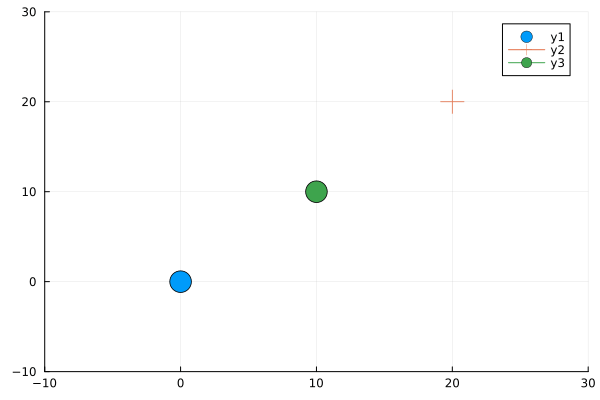

In [92]:
anim = @animate for t in 1:k_steps
    scatter([xₜ[t, 1]], [xₜ[t, 2]], m = (:circle, 12),
    xlims = (-10, 30), 
    ylims = (-10, 30), )
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
    plot!([obstacle[1]], [obstacle[2]], m = (:circle, 12))
end every 10;
gif(anim, "obstacle.gif")

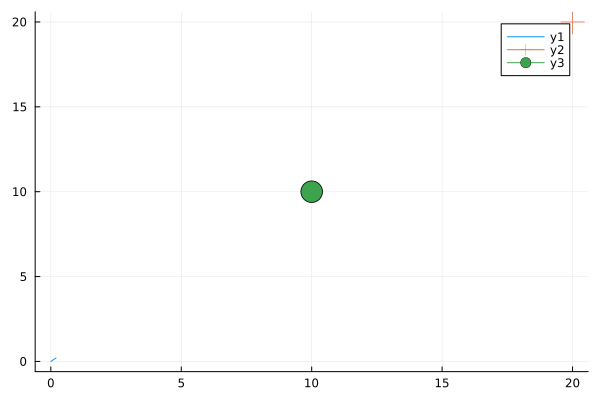

In [93]:
plot([xₜ[:, 1]], [xₜ[:, 2]])
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
plot!([obstacle[1]], [obstacle[2]], m = (:circle, 12))

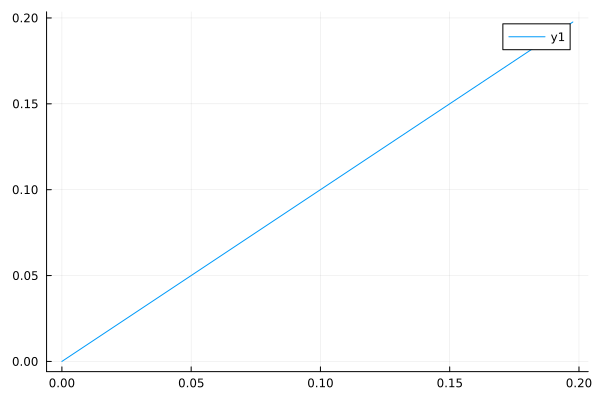

In [94]:
plot([xₜ[:, 1]], [xₜ[:, 2]])

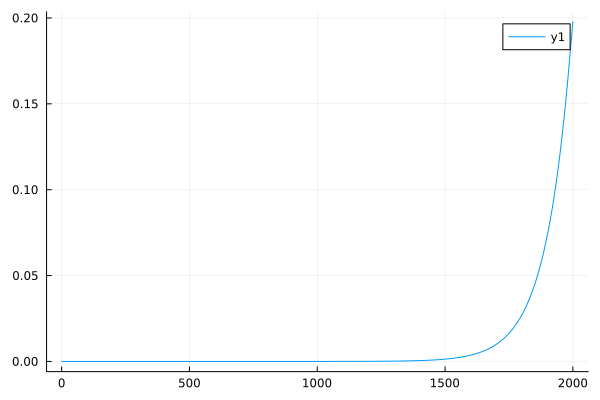

In [95]:
plot([xₜ[:, 2]])

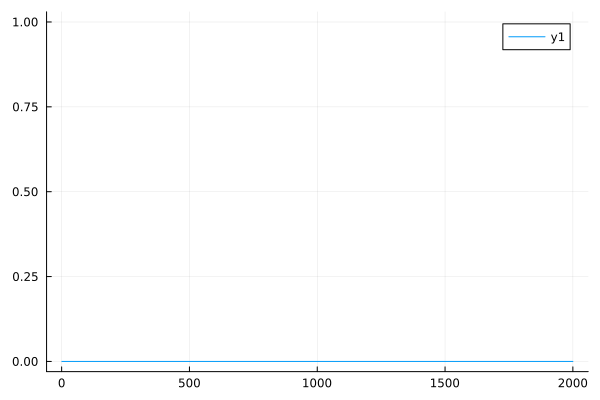

In [96]:
plot(costs)